In [25]:
%matplotlib inline

import sys
sys.path.append("../")


import fbprophet
import matplotlib.pyplot as plt
from src import dataset


In [32]:
excel_file = "20160921-analysisofestimatedarrivals.xlsx"
df = dataset.load_excel(excel_file)

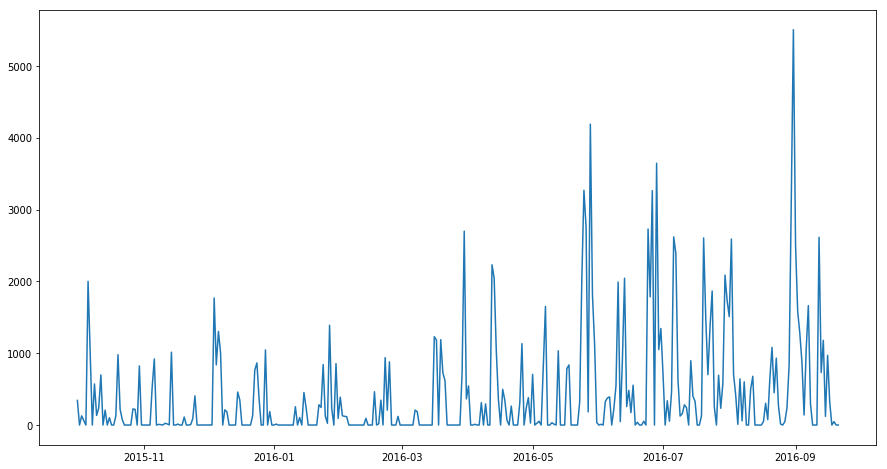

In [33]:
plt.figure(figsize=(15,8))
plt.plot(df.index, df["Arrivals to Italy"])
plt.show()

In [34]:
df.head()

,Arrivals to Italy
Date,
2015-10-01,343
2015-10-02,0
2015-10-03,128
2015-10-04,62
2015-10-05,0


In [52]:
# Resample by weeks
w_df = df.resample("W").sum()
w_df = w_df.reset_index().rename(columns={'Date': 'ds', 'Arrivals to Italy': 'y'})

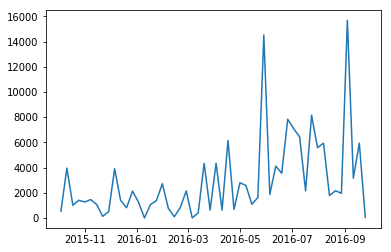

In [51]:
plt.plot(w_df["ds"], w_df["y"])
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


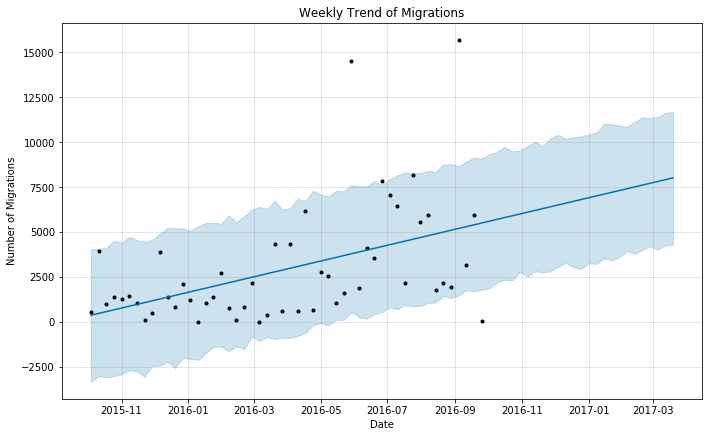

In [54]:
ph_model = fbprophet.Prophet(changepoint_prior_scale=0.14)
ph_model.fit(w_df)
ph_forecast = ph_model.make_future_dataframe(periods=25, freq='W')
ph_forecast = ph_model.predict(ph_forecast)

ph_model.plot(ph_forecast, xlabel = 'Date', ylabel = 'Number of Migrations')
plt.title('Weekly Trend of Migrations')
plt.show()